# Mutation

In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn

import pickle
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append("../Scripts/")
from models import model_v3
from util_funs import seq2index, cutseqs, highest_x, index2word_, word2index_
from util_att import evaluate, cal_attention
from util_mutation import mutate_withinattention_single, mutate_outatt_single

In [3]:
middle_index = 499
length = 51  
radius = length // 2
num_task = 12
data_index = 841 # 841,833,802
my_dict = pickle.load(open('../Data/embeddings_12RM_new2.pkl','rb'))

## Three available datatypes to use (one hot, char, 3-mers)

In [4]:
RM_data = h5py.File('../Data/data_12RM.h5','r')
RM_data.keys()

<KeysViewHDF5 ['test_in', 'test_in_3_mers', 'test_in_nucleo', 'test_out', 'train_in', 'train_in_3_mers', 'train_in_nucleo', 'train_out', 'valid_in', 'valid_in_3_mers', 'valid_in_nucleo', 'valid_out']>

In [10]:
RMs = ['Am','Cm','Gm','Um','m1A','m5C','m5U','m6A','m6Am','m7G','Psi','AtoI']
RMs_index2name = {i: RMs[i] for i in range(0,len(RMs))}
RMs_name2diff = {'In_att':[], 'Out_att':[], 'Class':[]}   # store probabilities difference after mutation

In [11]:
for repeat in range(0,1000):
    # prepare data 
    input_x = pd.read_hdf('../Data/data_12RM.h5','test_in_3_mers')       # 3-mers type
    input_x = input_x.iloc[:,middle_index-radius+1:middle_index+radius-1+1].sample(n=20) # test n samples every time
    input_x.applymap(lambda x: index2word_(my_dict)[x])
    input_x_index = input_x.index
    input_x = torch.cuda.FloatTensor(input_x.to_numpy())


    input_x_nucleo = pd.read_hdf('../Data/data_12RM.h5','test_in_nucleo')  # nucleo type
    input_x_nucleo = input_x_nucleo.iloc[input_x_index,middle_index-radius+1:middle_index+radius+2]
    input_x_nucleo_unmutated = input_x_nucleo.copy()
    input_x_nucleo_mutated_withinatt = input_x_nucleo.copy()              # copy of mutation
    input_x_nucleo_mutated_outatt = input_x_nucleo.copy()                 # copy of mutation

    y_true = pd.read_hdf('../Data/data_12RM.h5','test_out').iloc[input_x_index,:]

    # Initialize the model
    model = model_v3(num_task,use_embedding=True).cuda()
    model_path = '../Weights/MultiRM/trained_model_51seqs.pkl'
    model.load_state_dict(torch.load(model_path))

    # Input data into model and calculate attention weights
    attention_weights, y_preds = evaluate(model,input_x)
    y_probs = np.array([[y_pred.detach().cpu().numpy()[i] for y_pred in y_preds] for i in range(len(input_x))]) # reformulate probs
    # y_probs = y_probs[np.where(y_true==1)]  # select positive sample (may contain TPs, FPs)

    attention = cal_attention(attention_weights)

    # Calulate highest attention windows
    position_dict = dict()
    for sample_idx,class_idx in zip(np.arange(0,len(y_probs)),np.where(y_true==1)[1]):
        #dict_idx = y_true.index[sample_idx]
        tmp = highest_x(attention[sample_idx, class_idx, :],w=5)
        position_dict[sample_idx] = tmp

    # Perform mutation based on top-2 highest attention windows    
    for key, value in position_dict.items(): 
        exclude = (value[1][1:], value[2][1:]) # take the top 2 windows
        mutate_withinattention_single(input_x_nucleo_mutated_withinatt.iloc[key],exclude)
        mutate_outatt_single(input_x_nucleo_mutated_outatt.iloc[key], exclude)

    # Reformulate data
    input_x_mutated_withinatt_index = input_x_nucleo_mutated_withinatt.apply(lambda x: ''.join(x), axis=1
                                                                    ).apply(lambda x: seq2index([x],my_dict))
    input_x_mutated_outatt_index = input_x_nucleo_mutated_outatt.apply(lambda x: ''.join(x), axis=1
                                                               ).apply(lambda x: seq2index([x],my_dict))

    input_x_mutated_withinatt_index = np.vstack(input_x_mutated_withinatt_index.apply(lambda x: np.concatenate(x)).values)
    input_x_mutated_withinatt_index = torch.cuda.FloatTensor(input_x_mutated_withinatt_index)

    input_x_mutated_outatt_index = np.vstack(input_x_mutated_outatt_index.apply(lambda x: np.concatenate(x)).values)
    input_x_mutated_outatt_index = torch.cuda.FloatTensor(input_x_mutated_outatt_index)

    # feed mutated sequences into model and calculate its probability
    attention_weights_withatt, y_preds_withatt = evaluate(model,input_x_mutated_withinatt_index)
    y_probs_withatt = np.array([[y_pred.detach().cpu().numpy()[i] for y_pred in y_preds_withatt] for i in range(len(input_x))])
    # y_probs_withatt = y_probs_withatt[np.where(y_true==1)]

    attention_weights_outatt, y_preds_outatt = evaluate(model,input_x_mutated_outatt_index)
    y_probs_outatt = np.array([[y_pred.detach().cpu().numpy()[i] for y_pred in y_preds_outatt] for i in range(len(input_x))])
    # y_probs_outatt = y_probs_outatt[np.where(y_true==1)]


    for sample_idx, class_idx in zip(np.where(y_true==1)[0],np.where(y_true==1)[1]):
        diff_inatt = y_probs_withatt - y_probs
        diff_outatt = y_probs_outatt - y_probs
        RMs_name2diff['In_att'].append(diff_inatt[sample_idx,class_idx])
        RMs_name2diff['Out_att'].append(diff_outatt[sample_idx,class_idx])
        RMs_name2diff['Class'].append(RMs_index2name[class_idx])

# Visualize

In [12]:
diff_df = pd.DataFrame(RMs_name2diff)
diff_df_inatt = diff_df[['In_att','Class']].rename(columns={'In_att':'diff'})
diff_df_inatt['type'] = pd.Series(['In_att']*len(diff_df_inatt), dtype='string',name='type')

diff_df_outatt = diff_df[['Out_att','Class']].rename(columns={'Out_att':'diff'})
diff_df_outatt['type'] = pd.Series(['Out_att']*len(diff_df_inatt), dtype='string',name='type')

diff_df_2 = pd.concat([diff_df_inatt,diff_df_outatt])

In [13]:
diff_df_inatt.shape

(10128, 3)

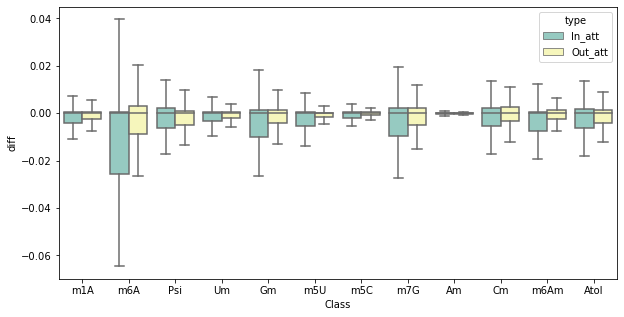

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x="Class", y="diff", hue="type",
                 data=diff_df_2, palette="Set3",showfliers=False,ax=ax)
fig.savefig('../Figs/mutation.pdf')